# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Sigmoid(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Sigmoid(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Sigmoid(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.9080
Epoch 1/200, Iteration 2/12, Loss: 2.1880
Epoch 1/200, Iteration 3/12, Loss: 0.8354
Epoch 1/200, Iteration 4/12, Loss: 0.9086
Epoch 1/200, Iteration 5/12, Loss: 1.1283
Epoch 1/200, Iteration 6/12, Loss: 1.0334
Epoch 1/200, Iteration 7/12, Loss: 1.0386
Epoch 1/200, Iteration 8/12, Loss: 0.8206
Epoch 1/200, Iteration 9/12, Loss: 0.7968
Epoch 1/200, Iteration 10/12, Loss: 0.8362
Epoch 1/200, Iteration 11/12, Loss: 0.8908
Epoch 1/200, Iteration 12/12, Loss: 0.8664
Epoch 1/200, Iteration 13/12, Loss: 0.7900
Train Error: 
 Accuracy: 77.0%, Avg loss: 0.854335, MRE: 0.592707, MAE: 0.116047 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.773115, MRE: 0.475756, MAE: 0.101682 

Epoch 2/200, Iteration 1/12, Loss: 0.8333
Epoch 2/200, Iteration 2/12, Loss: 0.8604
Epoch 2/200, Iteration 3/12, Loss: 0.7217
Epoch 2/200, Iteration 4/12, Loss: 0.8077
Epoch 2/200, Iteration 5/12, Loss: 0.9290
Epoch 2/200, Iteration 6/12, Loss: 0.8051
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 74.0%, Avg loss: 0.097089, MRE: 0.077037, MAE: 0.012221 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.084397, MRE: 0.058146, MAE: 0.010843 

Epoch 13/200, Iteration 1/12, Loss: 0.0903
Epoch 13/200, Iteration 2/12, Loss: 0.1531
Epoch 13/200, Iteration 3/12, Loss: 0.1674
Epoch 13/200, Iteration 4/12, Loss: 0.0881
Epoch 13/200, Iteration 5/12, Loss: 0.1586
Epoch 13/200, Iteration 6/12, Loss: 0.1306
Epoch 13/200, Iteration 7/12, Loss: 0.1155
Epoch 13/200, Iteration 8/12, Loss: 0.1121
Epoch 13/200, Iteration 9/12, Loss: 0.1264
Epoch 13/200, Iteration 10/12, Loss: 0.1193
Epoch 13/200, Iteration 11/12, Loss: 0.1120
Epoch 13/200, Iteration 12/12, Loss: 0.1544
Epoch 13/200, Iteration 13/12, Loss: 0.1552
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.111035, MRE: 0.079767, MAE: 0.016300 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.109935, MRE: 0.068913, MAE: 0.016184 

Epoch 14/200, Iteration 1/12, Loss: 0.1029
Epoch 14/200, Iteration 2/12, Loss: 0.1347
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 37.75%, Avg loss: 0.104878, MRE: 0.084690, MAE: 0.012152 

Test Error: 
 Accuracy: 36.0%, Avg loss: 0.103136, MRE: 0.077745, MAE: 0.011584 

Epoch 25/200, Iteration 1/12, Loss: 0.1098
Epoch 25/200, Iteration 2/12, Loss: 0.0899
Epoch 25/200, Iteration 3/12, Loss: 0.0739
Epoch 25/200, Iteration 4/12, Loss: 0.0982
Epoch 25/200, Iteration 5/12, Loss: 0.0705
Epoch 25/200, Iteration 6/12, Loss: 0.0742
Epoch 25/200, Iteration 7/12, Loss: 0.0787
Epoch 25/200, Iteration 8/12, Loss: 0.0693
Epoch 25/200, Iteration 9/12, Loss: 0.0844
Epoch 25/200, Iteration 10/12, Loss: 0.0609
Epoch 25/200, Iteration 11/12, Loss: 0.0877
Epoch 25/200, Iteration 12/12, Loss: 0.0505
Epoch 25/200, Iteration 13/12, Loss: 0.0540
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.061302, MRE: 0.046812, MAE: 0.007080 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.057911, MRE: 0.040011, MAE: 0.006643 

Epoch 26/200, Iteration 1/12, Loss: 0.0622
Epoch 26/200, Iteration 2/12, Loss: 0.0601
Epoch 26/200, Itera

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.042960, MRE: 0.036013, MAE: 0.005040 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.042161, MRE: 0.030610, MAE: 0.004920 

Epoch 37/200, Iteration 1/12, Loss: 0.0460
Epoch 37/200, Iteration 2/12, Loss: 0.0497
Epoch 37/200, Iteration 3/12, Loss: 0.0728
Epoch 37/200, Iteration 4/12, Loss: 0.0594
Epoch 37/200, Iteration 5/12, Loss: 0.0617
Epoch 37/200, Iteration 6/12, Loss: 0.0506
Epoch 37/200, Iteration 7/12, Loss: 0.0666
Epoch 37/200, Iteration 8/12, Loss: 0.0749
Epoch 37/200, Iteration 9/12, Loss: 0.0667
Epoch 37/200, Iteration 10/12, Loss: 0.0565
Epoch 37/200, Iteration 11/12, Loss: 0.0563
Epoch 37/200, Iteration 12/12, Loss: 0.0784
Epoch 37/200, Iteration 13/12, Loss: 0.0634
Train Error: 
 Accuracy: 86.62%, Avg loss: 0.055261, MRE: 0.040962, MAE: 0.006829 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.055122, MRE: 0.038471, MAE: 0.006845 

Epoch 38/200, Iteration 1/12, Loss: 0.0506
Epoch 38/200, Iteration 2/12, Loss: 0.0545
Epoch 38/200, Iterat

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.023876, MRE: 0.022815, MAE: 0.002938 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.025531, MRE: 0.018829, MAE: 0.003111 

Epoch 49/200, Iteration 1/12, Loss: 0.0216
Epoch 49/200, Iteration 2/12, Loss: 0.0237
Epoch 49/200, Iteration 3/12, Loss: 0.0216
Epoch 49/200, Iteration 4/12, Loss: 0.0206
Epoch 49/200, Iteration 5/12, Loss: 0.0210
Epoch 49/200, Iteration 6/12, Loss: 0.0214
Epoch 49/200, Iteration 7/12, Loss: 0.0233
Epoch 49/200, Iteration 8/12, Loss: 0.0272
Epoch 49/200, Iteration 9/12, Loss: 0.0267
Epoch 49/200, Iteration 10/12, Loss: 0.0232
Epoch 49/200, Iteration 11/12, Loss: 0.0251
Epoch 49/200, Iteration 12/12, Loss: 0.0213
Epoch 49/200, Iteration 13/12, Loss: 0.0196
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.022157, MRE: 0.020467, MAE: 0.002711 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.024486, MRE: 0.018670, MAE: 0.002965 

Epoch 50/200, Iteration 1/12, Loss: 0.0233
Epoch 50/200, Iteration 2/12, Loss: 0.0243
Epoch 50/200, Iter

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.023143, MRE: 0.017357, MAE: 0.002794 

Epoch 61/200, Iteration 1/12, Loss: 0.0243
Epoch 61/200, Iteration 2/12, Loss: 0.0188
Epoch 61/200, Iteration 3/12, Loss: 0.0190
Epoch 61/200, Iteration 4/12, Loss: 0.0202
Epoch 61/200, Iteration 5/12, Loss: 0.0156
Epoch 61/200, Iteration 6/12, Loss: 0.0210
Epoch 61/200, Iteration 7/12, Loss: 0.0187
Epoch 61/200, Iteration 8/12, Loss: 0.0173
Epoch 61/200, Iteration 9/12, Loss: 0.0200
Epoch 61/200, Iteration 10/12, Loss: 0.0207
Epoch 61/200, Iteration 11/12, Loss: 0.0206
Epoch 61/200, Iteration 12/12, Loss: 0.0204
Epoch 61/200, Iteration 13/12, Loss: 0.0235
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.019479, MRE: 0.018633, MAE: 0.002412 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.021627, MRE: 0.016539, MAE: 0.002623 

Epoch 62/200, Iteration 1/12, Loss: 0.0172
Epoch 62/200, Iteration 2/12, Loss: 0.0162
Epoch 62/200, Iteration 3/12, Loss: 0.0204
Epoch 62/200, Iteration 4/12, Loss: 0.0194
Epoch 62/200, It

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.019020, MRE: 0.018077, MAE: 0.002351 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021244, MRE: 0.016126, MAE: 0.002583 

Epoch 73/200, Iteration 1/12, Loss: 0.0228
Epoch 73/200, Iteration 2/12, Loss: 0.0198
Epoch 73/200, Iteration 3/12, Loss: 0.0190
Epoch 73/200, Iteration 4/12, Loss: 0.0150
Epoch 73/200, Iteration 5/12, Loss: 0.0195
Epoch 73/200, Iteration 6/12, Loss: 0.0171
Epoch 73/200, Iteration 7/12, Loss: 0.0151
Epoch 73/200, Iteration 8/12, Loss: 0.0242
Epoch 73/200, Iteration 9/12, Loss: 0.0223
Epoch 73/200, Iteration 10/12, Loss: 0.0172
Epoch 73/200, Iteration 11/12, Loss: 0.0194
Epoch 73/200, Iteration 12/12, Loss: 0.0210
Epoch 73/200, Iteration 13/12, Loss: 0.0194
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.018745, MRE: 0.017941, MAE: 0.002291 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.021196, MRE: 0.016588, MAE: 0.002561 

Epoch 74/200, Iteration 1/12, Loss: 0.0219
Epoch 74/200, Iteration 2/12, Loss: 0.0204
Epoch 74/200, Itera

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.017594, MRE: 0.017288, MAE: 0.002109 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.020290, MRE: 0.015192, MAE: 0.002423 

Epoch 85/200, Iteration 1/12, Loss: 0.0155
Epoch 85/200, Iteration 2/12, Loss: 0.0173
Epoch 85/200, Iteration 3/12, Loss: 0.0184
Epoch 85/200, Iteration 4/12, Loss: 0.0207
Epoch 85/200, Iteration 5/12, Loss: 0.0163
Epoch 85/200, Iteration 6/12, Loss: 0.0179
Epoch 85/200, Iteration 7/12, Loss: 0.0230
Epoch 85/200, Iteration 8/12, Loss: 0.0214
Epoch 85/200, Iteration 9/12, Loss: 0.0190
Epoch 85/200, Iteration 10/12, Loss: 0.0162
Epoch 85/200, Iteration 11/12, Loss: 0.0217
Epoch 85/200, Iteration 12/12, Loss: 0.0196
Epoch 85/200, Iteration 13/12, Loss: 0.0173
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.019729, MRE: 0.018883, MAE: 0.002367 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.021502, MRE: 0.015540, MAE: 0.002590 

Epoch 86/200, Iteration 1/12, Loss: 0.0202
Epoch 86/200, Iteration 2/12, Loss: 0.0194
Epoch 86/200, Iter

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.018731, MRE: 0.016602, MAE: 0.002483 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.021342, MRE: 0.015733, MAE: 0.002714 

Epoch 97/200, Iteration 1/12, Loss: 0.0183
Epoch 97/200, Iteration 2/12, Loss: 0.0150
Epoch 97/200, Iteration 3/12, Loss: 0.0183
Epoch 97/200, Iteration 4/12, Loss: 0.0171
Epoch 97/200, Iteration 5/12, Loss: 0.0159
Epoch 97/200, Iteration 6/12, Loss: 0.0169
Epoch 97/200, Iteration 7/12, Loss: 0.0160
Epoch 97/200, Iteration 8/12, Loss: 0.0164
Epoch 97/200, Iteration 9/12, Loss: 0.0167
Epoch 97/200, Iteration 10/12, Loss: 0.0202
Epoch 97/200, Iteration 11/12, Loss: 0.0146
Epoch 97/200, Iteration 12/12, Loss: 0.0165
Epoch 97/200, Iteration 13/12, Loss: 0.0193
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.016579, MRE: 0.017853, MAE: 0.002088 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019631, MRE: 0.015044, MAE: 0.002416 

Epoch 98/200, Iteration 1/12, Loss: 0.0160
Epoch 98/200, Iteration 2/12, Loss: 0.0130
Epoch 98/200, Iter

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018589, MRE: 0.014217, MAE: 0.002239 

Epoch 109/200, Iteration 1/12, Loss: 0.0168
Epoch 109/200, Iteration 2/12, Loss: 0.0157
Epoch 109/200, Iteration 3/12, Loss: 0.0139
Epoch 109/200, Iteration 4/12, Loss: 0.0146
Epoch 109/200, Iteration 5/12, Loss: 0.0110
Epoch 109/200, Iteration 6/12, Loss: 0.0133
Epoch 109/200, Iteration 7/12, Loss: 0.0162
Epoch 109/200, Iteration 8/12, Loss: 0.0164
Epoch 109/200, Iteration 9/12, Loss: 0.0140
Epoch 109/200, Iteration 10/12, Loss: 0.0133
Epoch 109/200, Iteration 11/12, Loss: 0.0145
Epoch 109/200, Iteration 12/12, Loss: 0.0148
Epoch 109/200, Iteration 13/12, Loss: 0.0157
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014649, MRE: 0.014743, MAE: 0.001792 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018651, MRE: 0.014062, MAE: 0.002254 

Epoch 110/200, Iteration 1/12, Loss: 0.0146
Epoch 110/200, Iteration 2/12, Loss: 0.0163
Epoch 110/200, Iteration 3/12, Loss: 0.0180
Epoch 110/200, Iteration 4/12, Loss: 0.0126

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018440, MRE: 0.014062, MAE: 0.002216 

Epoch 121/200, Iteration 1/12, Loss: 0.0152
Epoch 121/200, Iteration 2/12, Loss: 0.0153
Epoch 121/200, Iteration 3/12, Loss: 0.0144
Epoch 121/200, Iteration 4/12, Loss: 0.0137
Epoch 121/200, Iteration 5/12, Loss: 0.0143
Epoch 121/200, Iteration 6/12, Loss: 0.0115
Epoch 121/200, Iteration 7/12, Loss: 0.0129
Epoch 121/200, Iteration 8/12, Loss: 0.0148
Epoch 121/200, Iteration 9/12, Loss: 0.0169
Epoch 121/200, Iteration 10/12, Loss: 0.0115
Epoch 121/200, Iteration 11/12, Loss: 0.0139
Epoch 121/200, Iteration 12/12, Loss: 0.0152
Epoch 121/200, Iteration 13/12, Loss: 0.0199
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014433, MRE: 0.014602, MAE: 0.001757 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018353, MRE: 0.014052, MAE: 0.002205 

Epoch 122/200, Iteration 1/12, Loss: 0.0180
Epoch 122/200, Iteration 2/12, Loss: 0.0156
Epoch 122/200, Iteration 3/12, Loss: 0.0134
Epoch 122/200, Iteration 4/12, Loss: 0.0139

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014646, MRE: 0.014927, MAE: 0.001785 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018358, MRE: 0.013940, MAE: 0.002213 

Epoch 133/200, Iteration 1/12, Loss: 0.0149
Epoch 133/200, Iteration 2/12, Loss: 0.0130
Epoch 133/200, Iteration 3/12, Loss: 0.0148
Epoch 133/200, Iteration 4/12, Loss: 0.0185
Epoch 133/200, Iteration 5/12, Loss: 0.0126
Epoch 133/200, Iteration 6/12, Loss: 0.0144
Epoch 133/200, Iteration 7/12, Loss: 0.0159
Epoch 133/200, Iteration 8/12, Loss: 0.0141
Epoch 133/200, Iteration 9/12, Loss: 0.0143
Epoch 133/200, Iteration 10/12, Loss: 0.0138
Epoch 133/200, Iteration 11/12, Loss: 0.0129
Epoch 133/200, Iteration 12/12, Loss: 0.0142
Epoch 133/200, Iteration 13/12, Loss: 0.0143
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014400, MRE: 0.014832, MAE: 0.001752 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018419, MRE: 0.014053, MAE: 0.002213 

Epoch 134/200, Iteration 1/12, Loss: 0.0187
Epoch 134/200, Iteration 2/12, Loss: 0.0167
Epoc

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014055, MRE: 0.014409, MAE: 0.001713 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018154, MRE: 0.013829, MAE: 0.002182 

Epoch 145/200, Iteration 1/12, Loss: 0.0138
Epoch 145/200, Iteration 2/12, Loss: 0.0140
Epoch 145/200, Iteration 3/12, Loss: 0.0137
Epoch 145/200, Iteration 4/12, Loss: 0.0133
Epoch 145/200, Iteration 5/12, Loss: 0.0147
Epoch 145/200, Iteration 6/12, Loss: 0.0122
Epoch 145/200, Iteration 7/12, Loss: 0.0111
Epoch 145/200, Iteration 8/12, Loss: 0.0170
Epoch 145/200, Iteration 9/12, Loss: 0.0131
Epoch 145/200, Iteration 10/12, Loss: 0.0151
Epoch 145/200, Iteration 11/12, Loss: 0.0177
Epoch 145/200, Iteration 12/12, Loss: 0.0139
Epoch 145/200, Iteration 13/12, Loss: 0.0133
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013966, MRE: 0.014225, MAE: 0.001701 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018173, MRE: 0.013852, MAE: 0.002185 

Epoch 146/200, Iteration 1/12, Loss: 0.0120
Epoch 146/200, Iteration 2/12, Loss: 0.0130
Epoc

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013991, MRE: 0.014334, MAE: 0.001704 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018181, MRE: 0.013875, MAE: 0.002186 

Epoch 157/200, Iteration 1/12, Loss: 0.0154
Epoch 157/200, Iteration 2/12, Loss: 0.0139
Epoch 157/200, Iteration 3/12, Loss: 0.0162
Epoch 157/200, Iteration 4/12, Loss: 0.0165
Epoch 157/200, Iteration 5/12, Loss: 0.0133
Epoch 157/200, Iteration 6/12, Loss: 0.0130
Epoch 157/200, Iteration 7/12, Loss: 0.0169
Epoch 157/200, Iteration 8/12, Loss: 0.0103
Epoch 157/200, Iteration 9/12, Loss: 0.0126
Epoch 157/200, Iteration 10/12, Loss: 0.0137
Epoch 157/200, Iteration 11/12, Loss: 0.0131
Epoch 157/200, Iteration 12/12, Loss: 0.0135
Epoch 157/200, Iteration 13/12, Loss: 0.0149
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014191, MRE: 0.014775, MAE: 0.001728 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018181, MRE: 0.013873, MAE: 0.002186 

Epoch 158/200, Iteration 1/12, Loss: 0.0140
Epoch 158/200, Iteration 2/12, Loss: 0.0153
Epoc

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018179, MRE: 0.013872, MAE: 0.002186 

Epoch 168/200, Iteration 1/12, Loss: 0.0127
Epoch 168/200, Iteration 2/12, Loss: 0.0150
Epoch 168/200, Iteration 3/12, Loss: 0.0166
Epoch 168/200, Iteration 4/12, Loss: 0.0129
Epoch 168/200, Iteration 5/12, Loss: 0.0147
Epoch 168/200, Iteration 6/12, Loss: 0.0131
Epoch 168/200, Iteration 7/12, Loss: 0.0141
Epoch 168/200, Iteration 8/12, Loss: 0.0122
Epoch 168/200, Iteration 9/12, Loss: 0.0128
Epoch 168/200, Iteration 10/12, Loss: 0.0132
Epoch 168/200, Iteration 11/12, Loss: 0.0143
Epoch 168/200, Iteration 12/12, Loss: 0.0158
Epoch 168/200, Iteration 13/12, Loss: 0.0167
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013985, MRE: 0.014279, MAE: 0.001699 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018179, MRE: 0.013870, MAE: 0.002186 

Epoch 169/200, Iteration 1/12, Loss: 0.0131
Epoch 169/200, Iteration 2/12, Loss: 0.0147
Epoch 169/200, Iteration 3/12, Loss: 0.0156
Epoch 169/200, Iteration 4/12, Loss: 0.0144

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014278, MRE: 0.017878, MAE: 0.001749 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018178, MRE: 0.013867, MAE: 0.002186 

Epoch 180/200, Iteration 1/12, Loss: 0.0132
Epoch 180/200, Iteration 2/12, Loss: 0.0136
Epoch 180/200, Iteration 3/12, Loss: 0.0142
Epoch 180/200, Iteration 4/12, Loss: 0.0130
Epoch 180/200, Iteration 5/12, Loss: 0.0128
Epoch 180/200, Iteration 6/12, Loss: 0.0195
Epoch 180/200, Iteration 7/12, Loss: 0.0123
Epoch 180/200, Iteration 8/12, Loss: 0.0148
Epoch 180/200, Iteration 9/12, Loss: 0.0126
Epoch 180/200, Iteration 10/12, Loss: 0.0158
Epoch 180/200, Iteration 11/12, Loss: 0.0141
Epoch 180/200, Iteration 12/12, Loss: 0.0117
Epoch 180/200, Iteration 13/12, Loss: 0.0170
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014068, MRE: 0.014365, MAE: 0.001718 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018178, MRE: 0.013867, MAE: 0.002186 

Epoch 181/200, Iteration 1/12, Loss: 0.0135
Epoch 181/200, Iteration 2/12, Loss: 0.0143
Epoc

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013904, MRE: 0.014185, MAE: 0.001696 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018178, MRE: 0.013867, MAE: 0.002186 

Epoch 192/200, Iteration 1/12, Loss: 0.0127
Epoch 192/200, Iteration 2/12, Loss: 0.0140
Epoch 192/200, Iteration 3/12, Loss: 0.0147
Epoch 192/200, Iteration 4/12, Loss: 0.0130
Epoch 192/200, Iteration 5/12, Loss: 0.0128
Epoch 192/200, Iteration 6/12, Loss: 0.0179
Epoch 192/200, Iteration 7/12, Loss: 0.0124
Epoch 192/200, Iteration 8/12, Loss: 0.0144
Epoch 192/200, Iteration 9/12, Loss: 0.0106
Epoch 192/200, Iteration 10/12, Loss: 0.0162
Epoch 192/200, Iteration 11/12, Loss: 0.0152
Epoch 192/200, Iteration 12/12, Loss: 0.0157
Epoch 192/200, Iteration 13/12, Loss: 0.0126
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.014047, MRE: 0.014293, MAE: 0.001709 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018178, MRE: 0.013867, MAE: 0.002186 

Epoch 193/200, Iteration 1/12, Loss: 0.0151
Epoch 193/200, Iteration 2/12, Loss: 0.0178
Epoc

#### Plots loss vs Epoch

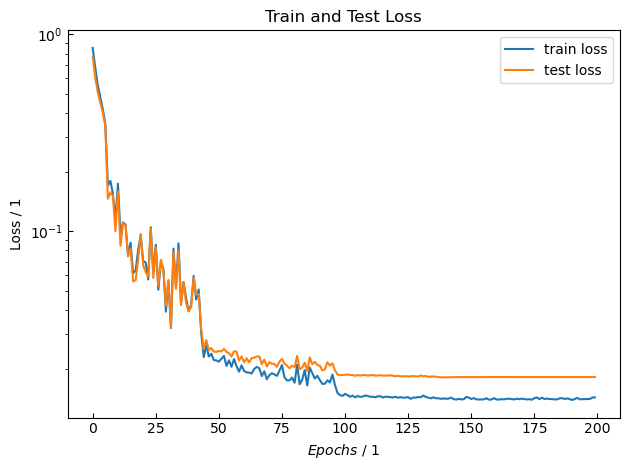

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
np.savez('data/models/hyperparams/loss_005_013.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9997090741253575 , R^2(NH3) = 0.9992050446171946
Test Dataset: R^2(H2) = 0.9997106539894504 , R^2(NH3) = 0.999224937402164
Max Error Training: |x_H2 - x_H2,pred| = 0.04136679429796397 , |x_NH3 - x_NH3,pred| = 0.017262471309324234
Max Error Test: |x_H2 - x_H2,pred| = 0.012210340522846086 , |x_NH3 - x_NH3,pred| = 0.009056582702640315


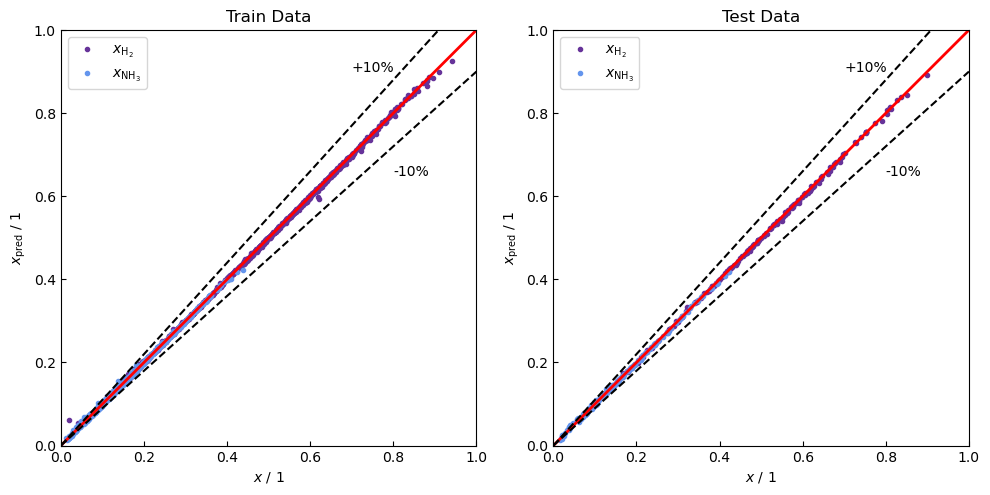

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

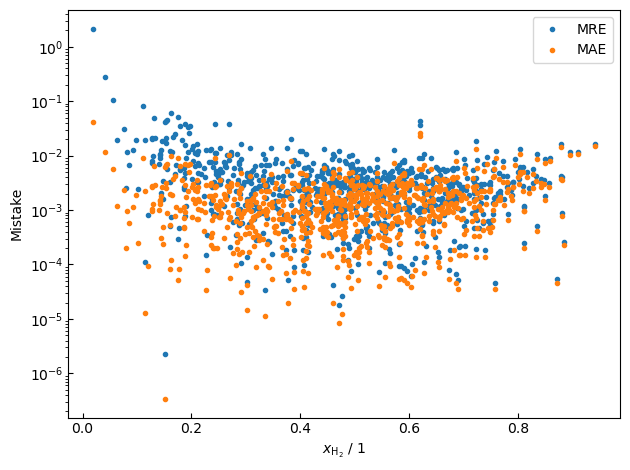

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

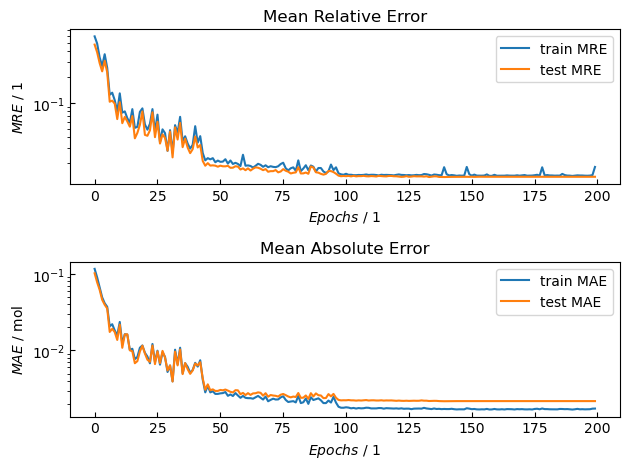

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

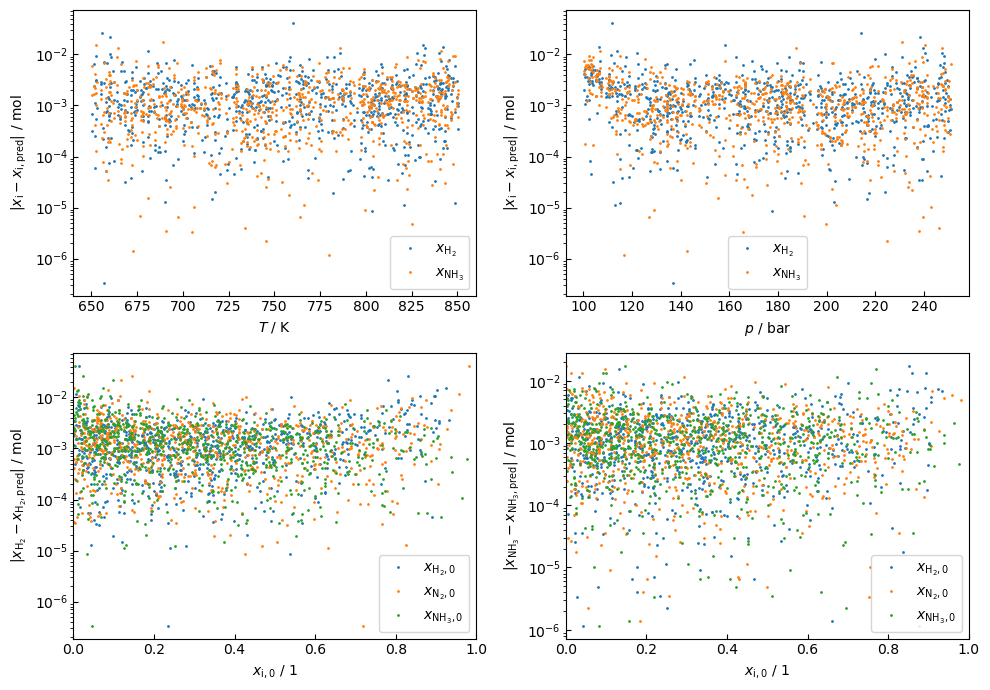

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

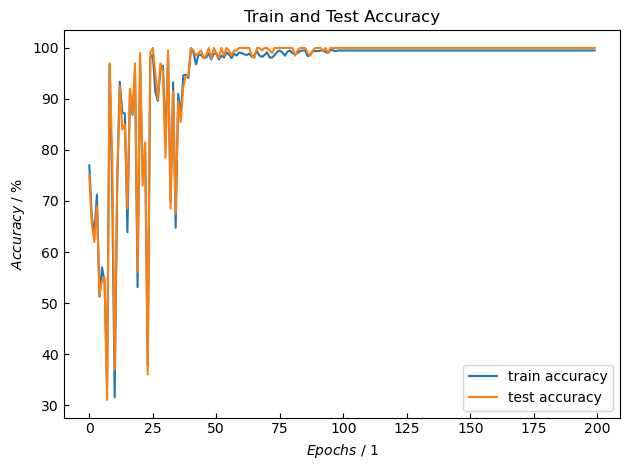

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.1757e+00, -1.6462e+00,  1.5086e+00, -1.3211e+00, -1.3026e-01],
        [-1.1636e+00,  2.1350e-01,  4.4045e-02,  3.8845e-02, -8.2928e-02],
        [-1.1362e+00, -1.1689e+00, -5.0226e-01,  3.1843e-01,  1.6746e-01],
        [-2.0690e-01, -1.6704e+00, -7.4753e-01, -9.2044e-01,  1.6744e+00],
        [-6.0637e-01, -7.3767e-01,  2.4468e-01,  1.0059e+00, -1.2682e+00],
        [-4.7751e-01, -1.4996e+00, -7.9300e-01, -1.5171e-02,  7.9374e-01],
        [-9.4457e-01,  1.4277e+00, -1.2097e+00, -2.2696e-01,  1.4191e+00],
        [-6.5848e-01,  1.2857e+00,  1.2868e+00, -2.2772e-01, -1.0301e+00],
        [ 1.1288e+00,  8.8812e-01,  5.0622e-01, -5.8226e-01,  9.8313e-02],
        [-1.0963e+00,  1.4259e+00, -4.2807e-01, -3.2783e-01,  7.5517e-01],
        [-1.4871e+00,  7.2158e-02, -7.2111e-01,  7.1222e-01, -2.0251e-02],
        [ 1.1188e+00, -3.4159e-01,  3.8753e-01, -1.1822e+00,  8.2796e-01],
        [ 1.1433e+00, -5.1337e-01,  5.8081e-01, -1.2671e+00,  7.2509e-01],
        [-8.3518e-01,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 5.8563e-01, -1.4071e-01, -5.3740e-01,  8.0052e-01, -8.3712e-02],
         [ 1.2867e-01,  9.5426e-02, -2.1702e-01, -7.6045e-02,  1.1321e+00],
         [ 3.3844e-01, -7.0270e-02,  7.0392e-01, -6.8969e-01,  6.0186e-01],
         [-6.9876e-01,  3.4939e-01, -4.7752e-01,  6.0873e-01, -1.4310e-01],
         [ 6.3762e-01, -4.7790e-01, -7.2481e-01,  5.9017e-01, -4.3760e-02],
         [ 8.4147e-01, -4.7810e-01,  4.9724e-01, -6.3731e-01,  2.2201e-01],
         [ 6.9573e-01, -2.9172e-01,  2.2925e-01, -6.5816e-01,  2.3642e-01],
         [ 9.0010e-01, -6.3439e-02,  2.4651e-01, -2.0307e-01,  3.7535e-01],
         [ 7.5135e-01, -1.6236e-01,  3.4436e-01, -3.6368e-01,  1.9904e-01],
         [ 2.1789e-01, -5.0854e-02, -7.4662e-01,  4.9095e-01, -4.9763e-01],
         [ 8.0575e-01, -8.5346e-01,  3.0323e-01, -4.1768e-01,  1.6711e-01],
         [ 2.3174e-01,  2.0893e-02,  3.8712e-01, -7.0799e-01,  2.5623e-01],
         [ 1.0389e+00, -2.3198e-01,  1.3129e-01, -6.3255e-01, -1.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7155, 0.0793, 0.9035, 0.2509, 0.5684],
        [0.1173, 0.4476, 0.8320, 0.1111, 0.5601]])
tensor([[ 0.6194, -0.2339],
        [ 0.4442,  0.3728]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.9026,  1.0255,  0.4608, -0.7997,  0.3652],
        [-1.4818, -1.4456, -1.1667,  0.8072,  0.3199],
        [-1.4601,  0.4022,  0.8997, -0.7612, -0.1049],
        [-1.5105,  0.5068, -1.3877,  1.2629,  0.0711],
        [ 0.7190, -0.5025, -1.3108,  0.2847,  0.9954],
        [ 1.5181, -1.1482, -1.0569,  1.9644, -0.9705],
        [ 0.8707,  1.0656, -0.7654, -0.2625,  1.0195],
        [ 0.4482,  0.8906,  0.8755,  0.0900, -0.9511],
        [-0.9304,  0.3302, -0.0945, -1.1162,  1.2335],
        [-0.9108,  1.2135, -0.1213,  0.7474, -0.6448],
        [-1.5425,  0.3482,  2.0423, -1.0633, -0.9176],
        [-1.2655, -0.7443,  0.0043, -0.1475,  0.1466],
        [ 0.5427,  0.0982, -1.3514,  2.0746, -0.7942],
        [ 0.5433,  1.6653, -0.6743,  1.5499, -0.9224],
        [ 1.4779,  0.1072, -0.4863, -1.2151,  1.7192],
        [ 0.9027,  0.5931, -0.4091,  0.8752, -0.4931],
        [-1.0598,  1.4676,  0.1431, -0.6038,  0.4767],
        [-0.8945, -0.0693, -0.7766,  2.1134, -1.3979],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()